# Example for one region (bundesland)

The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.

In [1]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

Now to the fun stuff, we import our module!

In [2]:
try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19
    %load_ext autoreload
    %autoreload 2

The next thing we want to do is load a dataset from somewhere. For now there are two different sources i.e. the robert koch institute and the johns hopkins university. We will chose the rki for now!

In [3]:
rki = cov19.data_retrieval.RKI()
#It is important to download the dataset!
#One could also parse true to the constructor of the class to force an auto download
rki.download_all_available_data() 

INFO     [covid19_inference.data_retrieval] Using local file since no new data is available online.


,Unnamed: 0,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,NeuGenesen,AnzahlGenesen,date,date_ref
0,0,1,Schleswig-Holstein,LK Stormarn,A15-A34,M,1,0,3139975,1062,"22.04.2020, 00:00 Uhr",0,-9,0,1,2020-03-20,2020-03-15
1,1,1,Schleswig-Holstein,LK Stormarn,A15-A34,M,1,0,3139976,1062,"22.04.2020, 00:00 Uhr",0,-9,0,1,2020-03-20,2020-03-19
2,2,1,Schleswig-Holstein,LK Stormarn,A15-A34,M,1,0,3139977,1062,"22.04.2020, 00:00 Uhr",0,-9,0,1,2020-03-23,2020-03-16
3,3,1,Schleswig-Holstein,LK Stormarn,A15-A34,M,1,0,3139978,1062,"22.04.2020, 00:00 Uhr",0,-9,0,1,2020-03-25,2020-03-24
4,4,1,Schleswig-Holstein,LK Stormarn,A15-A34,M,1,0,3139979,1062,"22.04.2020, 00:00 Uhr",0,-9,0,1,2020-03-26,2020-03-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111250,111250,16,Thüringen,LK Greiz,A35-A59,M,1,0,3248970,16076,"22.04.2020, 00:00 Uhr",0,-9,-9,0,2020-04-16,2020-04-14
111251,111251,16,Thüringen,LK Greiz,A35-A59,M,1,0,3248971,16076,"22.04.2020, 00:00 Uhr",0,-9,-9,0,2020-04-16,2020-04-15
111252,111252,16,Thüringen,LK Greiz,A35-A59,W,1,0,3248972,16076,"22.04.2020, 00:00 Uhr",0,-9,0,1,2020-03-16,2020-03-11
111253,111253,16,Thüringen,LK Greiz,A35-A59,W,1,0,3248973,16076,"22.04.2020, 00:00 Uhr",0,-9,0,1,2020-03-16,2020-03-13


Wait for the download to finish. It will print a message!

We can now access this downloaded data by the attribute
```
rki.data
```
but normaly one would use the build in filter methods.
For example one could use
```
rki.get_confirmed()
rki.get_deaths()
rki.get_recovered()
```
to get different cases. One could also filter the output, possible args are: bundesland, landkreis, begin_date, end_date, date_type.

In [9]:
#Create dates for filter
bd = datetime.datetime(2020,3,10)
ed = datetime.datetime(2020,4,13)

total_cases = rki.get_confirmed(bundesland="Sachsen",begin_date=bd,end_date=ed)
new_cases_obs = np.diff(np.array(total_cases))
date_begin_data = datetime.datetime(2020,3,10)
date_end_data   = datetime.datetime(2020,4,13)
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 10

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 1)]

In [10]:
print(new_cases.shape)

(34,)


In [11]:
#print(model.ndim_sim)
#print(model.shape_sim)
#print(model.df_bundesland.shape)
#print(new_cases_inferred.ndim)
#print(new_cases_inferred_raw.ndim)
#print(new_I_t.ndim)
#print(lambda_t_log.ndim)

In [15]:
params_model = dict(new_cases_obs = new_cases_obs[:],
                    date_begin_data = date_begin_data,
                    num_days_forecast = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 83e6) 


with cov19.Cov19Model(**params_model) as model:
    
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    new_I_t = cov19.SIR(lambda_t_log, pr_median_mu=1/8)
    
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=10, 
                                               pr_median_scale_delay=0.3)
    
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    cov19.student_t_likelihood(new_cases_inferred)


pr_median_transient_len was set to default value 4
pr_sigma_transient_len was set to default value 0.5
pr_median_transient_len was set to default value 4
pr_sigma_transient_len was set to default value 0.5
pr_median_transient_len was set to default value 4
pr_sigma_transient_len was set to default value 0.5


In [ ]:
trace = pm.sample(model=model, tune=500, draws=500, init='advi+adapt_diag')

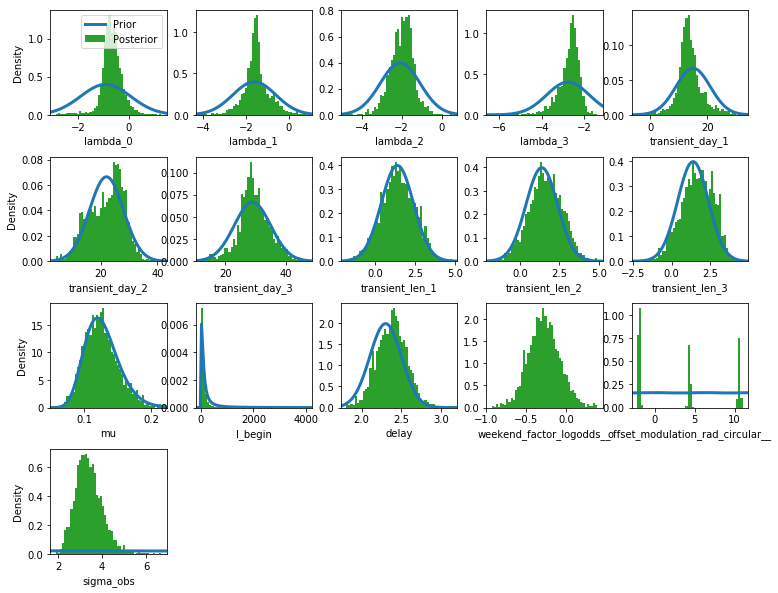

In [37]:
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)


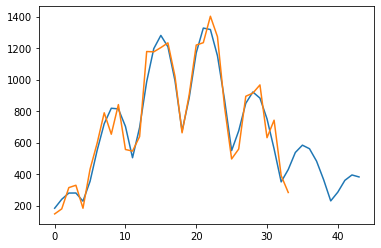

In [38]:
plt.plot(np.median(trace.new_cases, axis=0))
plt.plot(new_cases_obs[:,0])